Cuaderno de trabajo de:
 - _Piloto_ : Nombre1 Apellido1 (username con el que os habéis logueado)
 - _Copiloto_ : Nombre2 Apellido2 [escribe el username2]

# El problema del viajante (traveling salesman)

[https://es.wikipedia.org/wiki/Problema_del_viajante](https://es.wikipedia.org/wiki/Problema_del_viajante)

> El problema del vendedor viajero, problema del vendedor ambulante, problema del agente viajero o problema del viajante (TSP por sus siglas en inglés (Travelling Salesman Problem)), responde a la siguiente pregunta: dada una lista de ciudades y las distancias entre cada par de ellas, ¿cuál es la ruta más corta posible que visita cada ciudad exactamente una vez y al finalizar regresa a la ciudad origen? Este es un problema NP-Hard dentro en la optimización combinatoria, muy importante en la investigación de operaciones y en la ciencia de la computación. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optlang import Model, Variable, Constraint, Objective

In [2]:
COORDENADAS = np.array([
    [-0.0000000400893815,0.0000000358808126],
    [-43.0700258454450875,-14.5548396888330487],
    [-50.4808382862985496,-7.3744722432402208],
    [-14.6577381710829471,43.3895496964974043],
    [-64.7472605264735108,-21.8981713360336698],
    [-72.0785319657452987,-0.1815834632498404],
    [-79.2915791686897506,21.4033307581457670],
    [-65.0865638413727368,36.0624693073746769],
    [-36.0366489745023770,21.6135482886620949],
    [-29.0584693142401171,43.2167287683090606],
    [-21.4983260706612533,-7.3194159498090388],
    [-28.8732862244731230,-0.0000008724121069],
    [-57.5687244704708050,43.2505562436354225],
    [-50.5859026832315024,21.5881966132975371],
    [-0.1358203773809326,28.7292896751977480]
])
N, _ = COORDENADAS.shape

Dibujamos las ciudades

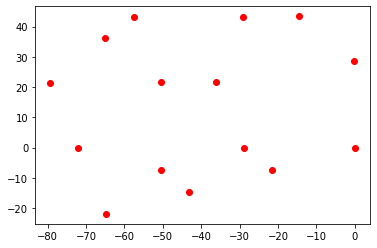

In [3]:
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'ro')

Si las unimos de cualquier manera, no obtenemos la ruta más corta

In [4]:
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'ro')
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'b')

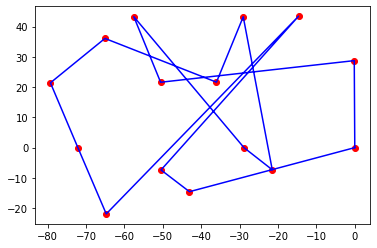

In [5]:
#Cerramos el camino volviendo al punto de partida
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'ro')
plt.plot(np.concatenate([COORDENADAS[:,0], COORDENADAS[:1,0]]),
         np.concatenate([COORDENADAS[:,1], COORDENADAS[:1,1]]), 'b')

Creamos una matriz con la distancia euclídea entre cada par de ciudades

In [6]:
import math
def d(p1,p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def matriz_distancias(coordenadas):
    N, _ = coordenadas.shape

    return np.array([
        [d(coordenadas[j], coordenadas[k]) for j in range(N) ]
        for k in range(N)
    ])

DISTANCIAS = matriz_distancias(COORDENADAS)

In [7]:
DISTANCIAS

array([[ 0.        , 45.46284727, 51.01664308, 45.79849678, 68.35011083,
        72.07876065, 82.1295141 , 74.40942465, 42.02125099, 52.07763703,
        22.71017112, 28.87328618, 72.00533761, 54.99985252, 28.72961069],
       [45.46284727,  0.        , 10.31880893, 64.53534188, 22.88726771,
        32.37412426, 51.03911193, 55.19818761, 36.84590451, 59.44642831,
        22.75279297, 20.33201291, 59.59593997, 36.91622242, 60.96607133],
       [51.01664308, 10.31880893,  0.        , 62.13115503, 20.35850286,
        22.76396322, 40.72125656, 45.82679468, 32.38734227, 54.93985359,
        28.98256451, 22.83131915, 51.11879928, 28.96285942, 61.95242088],
       [45.79849678, 64.53534188, 62.13115503,  0.        , 82.28880098,
        72.08044953, 68.27098377, 50.95834147, 30.51642286, 14.4017681 ,
        51.16827962, 45.65889733, 42.91121141, 42.02537331, 20.63514769],
       [68.35011083, 22.88726771, 20.35850286, 82.28880098,  0.        ,
        22.92068345, 45.67884946, 57.96163378, 

In [8]:
# Una forma de visualizar las distancias
plt.figure(figsize=(8,8))
im = plt.matshow(DISTANCIAS, fignum=1)
N, _ = DISTANCIAS.shape
for i in range(N):
    for j in range(N):
        plt.text(i,j,'%00.1f'%DISTANCIAS[i,j], ha='center', va='center')
cbar = plt.colorbar(im)
cbar.set_label('euclidean distance')
plt.title('Distance matrix from city i to city j')

Text(0.5, 1.05, 'Distance matrix from city i to city j')

Intentamos el siguiente planteamiento:

#### Variables

La variable ``c_3,4`` vale 1 si, cuando sale de la ciudad 3, el viajante va a la ciudad 4.

#### Restricciones

- ``c_4,0 + c_4,1 + c_4,2 + ... + c_4,N`` tiene que ser 1, porque cuando salga de la ciudad 4, no puede ir a dos ciudades distintas.
- ``c_0,4 + c_1,4 + ... + c_N,4`` tiene que ser 1, porque sólo puede llegar a la ciudad 4 una vez.

In [9]:
def VIAJANTE_v1(distancias):
    N,_ = distancias.shape
    model = Model(name='Viajante')

    c = [[Variable('c_%d,%d'%(i,j), type='binary')
          for i in range(N)]
          for j in range(N)
         ]
    constraints = []
    for i in range(N):
        #Solo se puede salir de la ciudad i una vez
        constraints.append(Constraint(sum(c[i][j] for j in range(N) if j!=i), ub=1, lb=1))
        #Solo se puede entrar en la ciudad i una vez
        constraints.append(Constraint(sum(c[j][i] for j in range(N) if j!=i), ub=1, lb=1))

    obj = Objective(sum(c[j][k]*distancias[j,k] for j in range(N) for k in range(N) if j!= k), 
                    direction='min')
    model.objective = obj
    model.add(constraints)
    return c, model

In [10]:
%%time
c, model = VIAJANTE_v1(DISTANCIAS)
model.optimize()
print(model.status)

optimal
CPU times: user 592 ms, sys: 3.25 ms, total: 595 ms
Wall time: 594 ms


In [11]:
def plot_path(variables, coordenadas):
    plt.figure()
    plt.plot(coordenadas[:,0], coordenadas[:,1], 'ro')
    for var_name, var in variables.iteritems():
        if var_name.count(',')!=1:
            continue
        si,sj = var_name[2:].split(',')
        i, j = int(si), int(sj)
        if var.primal>0:
            plt.plot([coordenadas[i,0], coordenadas[j,0]],
                     [coordenadas[i,1], coordenadas[j,1]], 'b')

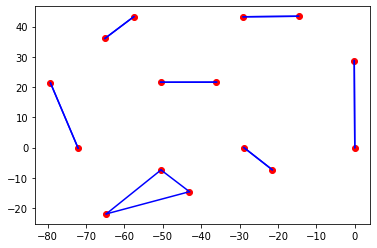

In [12]:
plot_path(model.variables, COORDENADAS)

### ¿Qué ha ocurrido?

La solución cumple las restricciones: de cada ciudad entra una vez, y sale una vez, pero ahora nos damos cuenta de que no es suficiente. El camino no es **conexo**, y no es lo que queríamos.

Intentamos resolverlo añadiendo más restricciones:

 - para cada par de ciudades (i,j), sólo puede haber una de las dos variables, o la c_ij, o la c_ji, pero no ambas (también permitimos que ambas sean 0, claro, para que ese trayecto pueda no formar parte del camino final).

In [13]:
for i in range(N):
    for j in range(N):
        model.add(Constraint(c[i][j] + c[j][i], ub=1))
model.optimize()
model.status

'optimal'

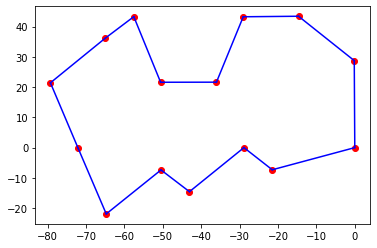

In [14]:
plot_path(model.variables, COORDENADAS)

### Ejercicio 1

Escribe una versión 2 del problema anterior, que directamente incluye las restricciones de que no se puede ir y volver por el mismo camino. Comprueba que de la solución correcta para el problema anterior

In [15]:
def VIAJANTE_v2(distancias):
    #TODO
    pass

### Ejercicio 2

¿Funciona la versión anterior con esta nueva lista de ciudades?

In [16]:
COORDENADAS2 = np.array([
    [0,0],
    [1,0],
    [1,1],
    [10,10],
    [10,12],
    [12,10]
])

DISTANCIAS2 = matriz_distancias(COORDENADAS2)
N2, _ = COORDENADAS2.shape

Hay varias formas de resolver el problema del camino no conexo:

 - Podemos intentar seguir añadiendo restricciones del tipo c_12 + c_23 + c_31<=2, que impide que las tres variables sean 1 a la vez, lo que correspondería a un camino cerrado. Es un enfoque popular, pero las restricciones no se añaden a priori, sino sobre la marcha, cada vez que una solución no corresponde a un camino conexo. Añadir todas esas restricciones antes de empezar es prohibitivo, porque la cantidad de tales restricciones crece de forma exponencial en el número de ciudades. _No seguiremos este enfoque_.

 - Podemos usar la siguiente solución [Miller-Tucker-Zemlin formulation en la wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Integer_linear_programming_formulations)

### Ejercicio 3

La formulación de Miller-Tucker-Zemlin consiste en:

 - Añadir variables adicionales $u_i$.
 - Añadir restricciones adicionales.
 
La siguiente versión del código intenta implementar esta formulación. Ya se han añadido las variables $u_i$, pero falta añadir las restricciones:

$$
u_i - u_j + N\cdot x_{ij} \leq N-1
$$

_sólo para $i\neq j$, y sólo desde $j=1$ hasta $j=N-1$:_


 - Termina el trabajo y comprueba la solución en el ejemplo anterior.

In [22]:
def VIAJANTE_v3(distancias):
    N,_ = distancias.shape
    model = Model(name='Viajante')

    c = [[Variable('c_%d,%d'%(i,j), type='binary')
          for i in range(N)]
          for j in range(N)
         ]
    #Añadimos las variables u de la formulación de Miller-Tucker-Zemlin
    u = [Variable('u(%d)'%i, type='integer') for i in range(N)]

    constraints = []
    for i in range(N):
        #Solo se puede salir de la ciudad i una vez
        constraints.append(Constraint(sum(c[i][j] for j in range(N) if j!=i), ub=1, lb=1))
        #Solo se puede entrar en la ciudad i una vez
        constraints.append(Constraint(sum(c[j][i] for j in range(N) if j!=i), ub=1, lb=1))

    #¡¡¡¡ TODO !!!!
    #Añade aquí las restricciones u_i - u_j + N c_ij <= N-1

    model.add(constraints)
        
    obj = Objective(sum(c[j][k]*distancias[j,k] for j in range(N) for k in range(N) if j!= k), 
                    direction='min')
    model.objective = obj

    return c, model

In [26]:
%%time

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS2)
model.optimize()
print(model.status)
plot_path(model.variables, COORDENADAS2)

optimal
CPU times: user 60.8 ms, sys: 0 ns, total: 60.8 ms
Wall time: 59.2 ms


optimal
CPU times: user 618 ms, sys: 0 ns, total: 618 ms
Wall time: 614 ms


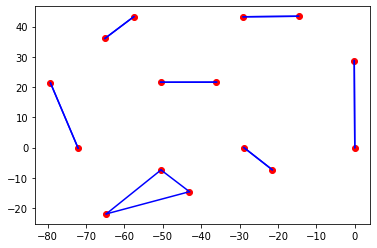

In [27]:
%%time

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS)
model.optimize()
print(model.status)
plot_path(model.variables, COORDENADAS)